___

<p style="text-align: center;"><img src="https://docs.google.com/uc?id=1lY0Uj5R04yMY3-ZppPWxqCr5pvBLYPnV" class="img-fluid" alt="CLRSWY"></p>

___

<h1 style="text-align: center;">Deep Learning<br><br>Assignment-1 (ANN)<br><br>Churn Prediction for Bank Customer<br><h1>

# Dataset Info

We have a dataset in which there are details of a bank's customers and the target variable is a binary variable reflecting the fact whether the customer left the bank (closed his account) or he continues to be a customer.

The features in the given dataset are:
- **rownumber:** Row Numbers from 1 to 10000.
- **customerid:** A unique ID that identifies each customer.
- **surname:** The customer’s surname.
- **creditscore:** A credit score is a number between 300–850 that depicts a consumer's creditworthiness.
- **geography:** The country from which the customer belongs to.
- **Gender:** The customer’s gender: Male, Female
- **Age:** The customer’s current age, in years, at the time of being customer.
- **tenure:** The number of years for which the customer has been with the bank.
- **balance:** Bank balance of the customer.
- **numofproducts:** the number of bank products the customer is utilising.
- **hascrcard:** The number of credit cards given to the customer by the bank.
- **isactivemember:** Binary Flag for indicating if the client is active or not with the bank before the moment where the client exits the company (recorded in the variable "exited")
- **exited:** Binary flag 1 if the customer closed account with bank and 0 if the customer is retained.

# Improt Libraries & Data

In [393]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,make_scorer,\
f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, RocCurveDisplay, roc_auc_score,roc_curve,auc
from sklearn.pipeline import make_pipeline
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam, Adadelta, RMSprop, Nadam
from tensorflow.keras.callbacks import EarlyStopping
from roc_utils import *
import warnings
import os
import optuna

warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
sns.set_style('whitegrid')

In [2]:
tf.__version__

'2.14.0'

In [133]:
optuna.__version__

'3.4.0'

In [3]:
df = pd.read_csv('Churn_Modelling.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# Exploratory Data Analysis and Visualization

1. Implement basic steps to see how is your data looks like
2. Check for missing values
3. Drop the features that not suitable for modelling
4. Implement basic visualization steps such as histogram, countplot, heatmap
5. Convert categorical variables to dummy variables

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [5]:
# checking for duplicates
df.duplicated().sum()

0

In [6]:
# checking for nulls 
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

### Dropping irrelavant features

In [7]:
# these features are irrelavant and cannot be used for prediction 
features_to_drop = ['RowNumber', 'CustomerId', 'Surname']

In [8]:
# dropping the features
df = df.drop(features_to_drop, axis=1)

### EDA

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00
Age,10000.0,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00
Tenure,10000.0,5.012800,2.892174,0.00,3.00,5.000,7.0000,10.00
Balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09
NumOfProducts,10000.0,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00
HasCrCard,10000.0,0.705500,0.455840,0.00,0.00,1.000,1.0000,1.00
IsActiveMember,10000.0,0.515100,0.499797,0.00,0.00,1.000,1.0000,1.00
EstimatedSalary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48
Exited,10000.0,0.203700,0.402769,0.00,0.00,0.000,0.0000,1.00


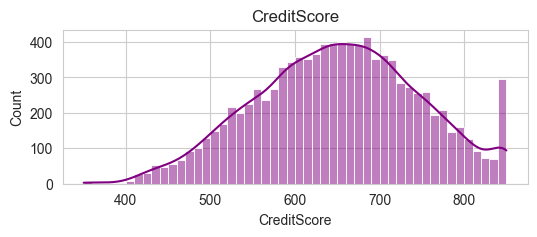

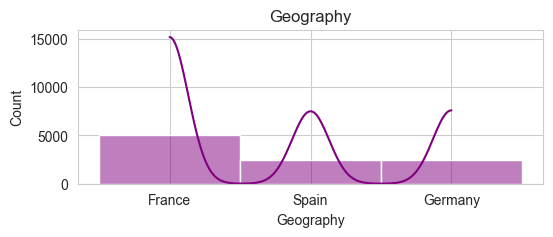

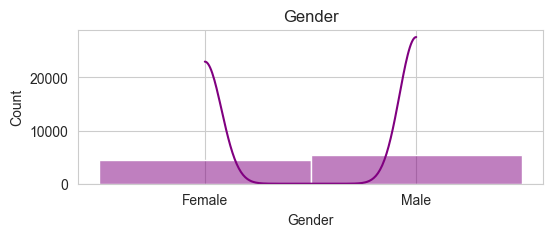

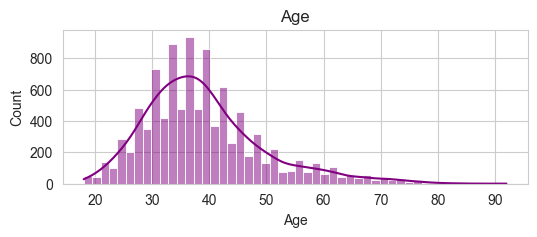

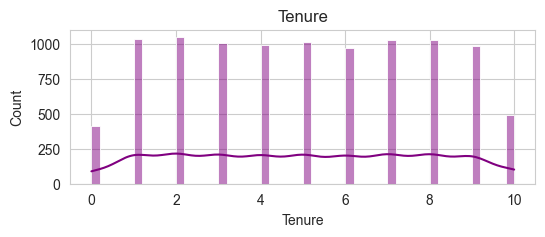

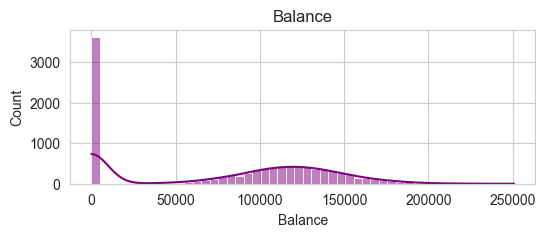

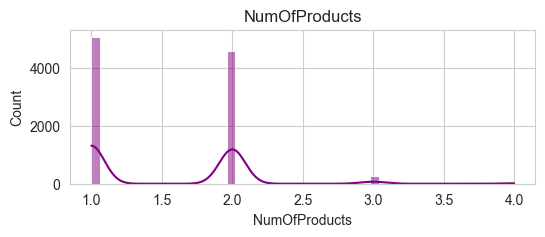

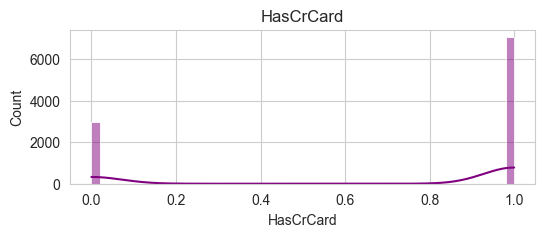

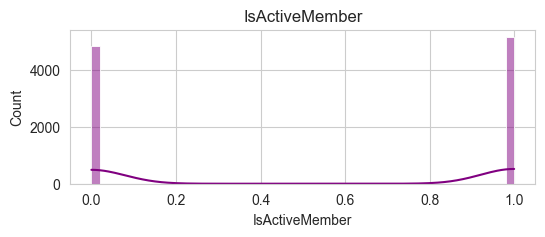

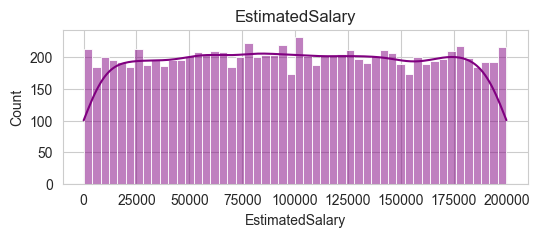

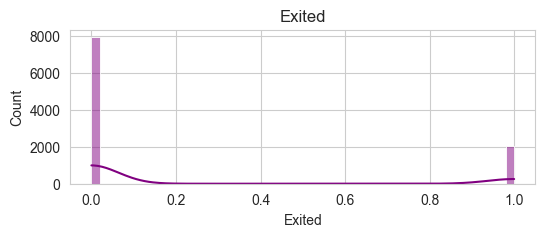

In [10]:
# visualizing the dist of columns
for column in df:
        plt.figure(figsize=(6,2))
        sns.histplot(df[column], bins=50, kde=True, color= 'purple')
        plt.title(f'{column}');

In [11]:
df['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

In [12]:
df.describe(include='object').T

,count,unique,top,freq
Geography,10000,3,France,5014
Gender,10000,2,Male,5457


In [13]:
df.groupby(['Gender']).mean()['CreditScore'].sort_values()

Gender
Male      650.276892
Female    650.831389
Name: CreditScore, dtype: float64

In [14]:
df.groupby(['Gender']).mean()['Balance'].sort_values()

Gender
Female    75659.369139
Male      77173.974506
Name: Balance, dtype: float64

In [15]:
df.groupby(['Gender']).mean()['EstimatedSalary'].sort_values()

Gender
Male       99664.576931
Female    100601.541382
Name: EstimatedSalary, dtype: float64

Not a huge difference between male and female in Salary, balance, and credit scores

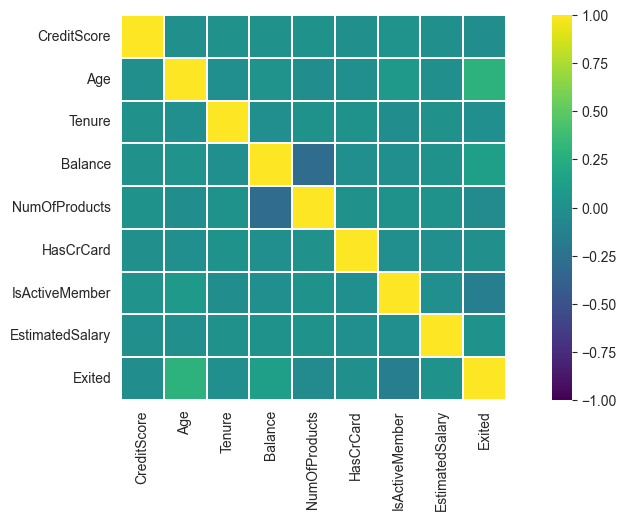

In [16]:
# correlation heatmap
plt.figure(figsize=(12, 5))
sns.heatmap(df.corr(numeric_only=True), 
            vmin=-1,
            vmax= 1,
            cmap= 'viridis', 
            linewidths=.12, 
            linecolor='white',
            fmt='.2g',
            square=True);

No features with high correlation scores

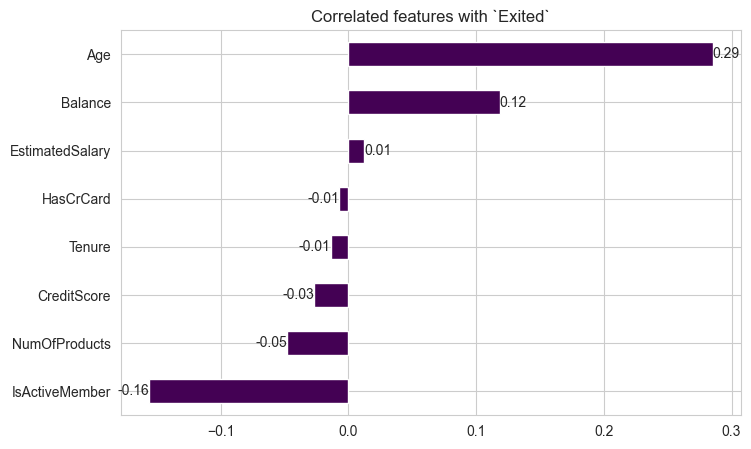

In [18]:
# correlated features with `Exited`
plt.figure(figsize=(8, 5))
ax = df.corr()['Exited'][:-1].sort_values().plot(kind='barh', colormap='viridis')
ax.bar_label(ax.containers[0], fmt="%.2f")
plt.title('Correlated features with `Exited`');

The `Age` and `Balance` are the most correlated features with our target `Exited`

### Checking outliers

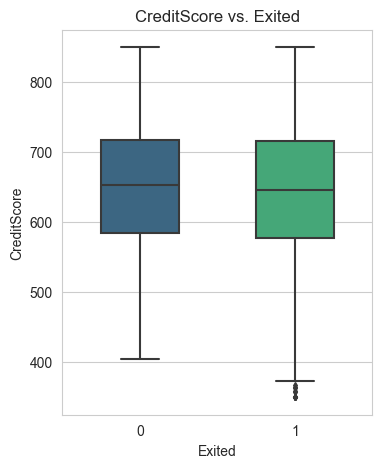

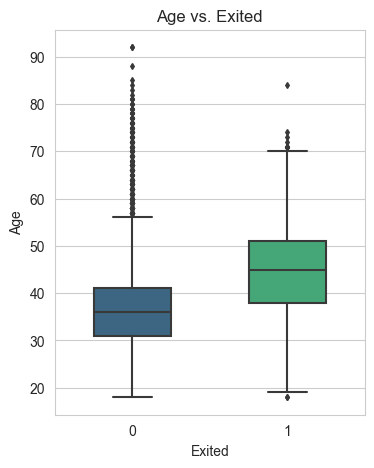

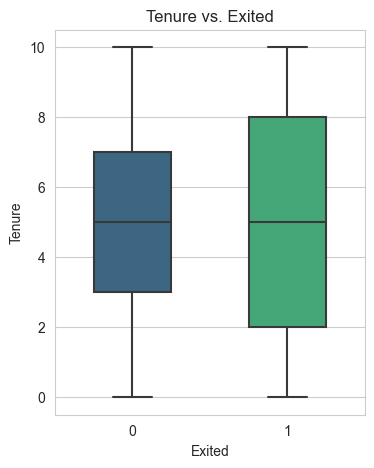

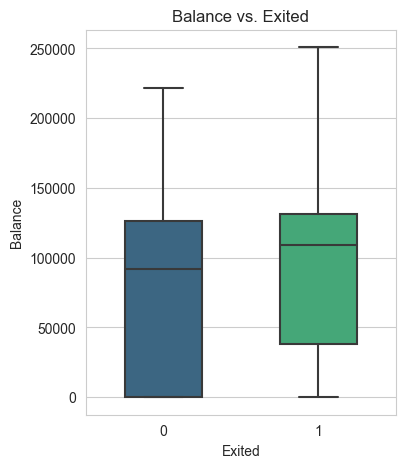

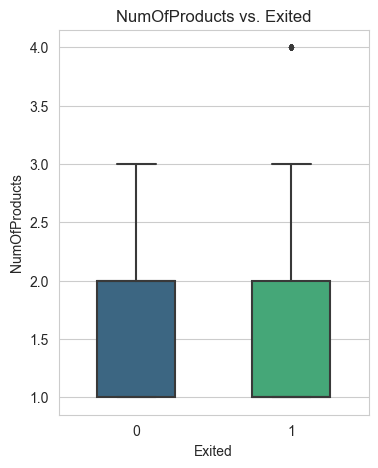

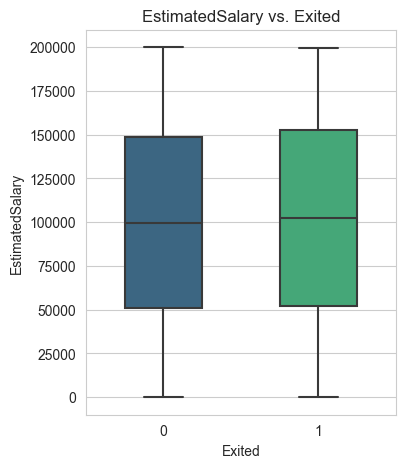

In [19]:
# store numerical columns names except target feature and categorical features
columns = list(df.select_dtypes(include=np.number).columns)

columns.remove('Exited')
columns.remove('IsActiveMember')
columns.remove('HasCrCard')

# print boxplot for each column with respect to y
for column in columns:
    plt.figure(figsize=(4, 5))
    sns.boxplot(data=df, width=0.5, fliersize=3, y=column, x='Exited', palette = 'viridis')
    plt.title(f'{column} vs. Exited')
    plt.show()

The effect of outliers can be unpredictable. we're gonna compare the results using Robust vs Standard vs MinMax.

In [20]:
categorical_features = ['IsActiveMember', 'HasCrCard', 'Gender' ,'Geography']

### Target feature

In [26]:
c = df['Exited'].value_counts()

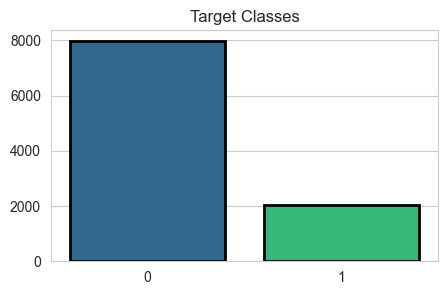

In [30]:
# visualizing our target distribution
plt.figure(figsize=(5, 3))
sns.barplot(x=c.index, y=c.values,
            saturation=1, edgecolor='k',
            linewidth=2, palette='viridis')
plt.title(f'Target Classes')
plt.show()

The target classes are not balanced, we must handle the imbalnced issue. <br>
Common approaches: 
- Focus on recall, precision, F1 scores for each class or (macro average)
- Use the class weight parameter to assign higher weights for the minority class
- On the data level: oversampling/undersampling

During the modeling process we will try to improve the performance for class 1 since it has more value in this business problem. Predicting customer churn may help in reducing the costs. 

## Column transformer

In [31]:
column_trans = make_column_transformer((
               OneHotEncoder( handle_unknown='ignore',
                              sparse_output=False), 
                              categorical_features),
                              remainder = 'passthrough', 
                              verbose_feature_names_out=False)

In [32]:
# we're gonna test three scalers
standard_scaler = StandardScaler()
robust_scaler = RobustScaler()
minmax_scaler = MinMaxScaler()

# Preprocessing of Data
- Train | Test Split, Scalling

In [33]:
# splitting X and y
X = df.drop(columns = ['Exited'])
y = df['Exited']

In [97]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.1, stratify=y, random_state = 42)

In [98]:
# transforming X
X_train = column_trans.fit_transform(X_train)
X_test = column_trans.transform(X_test)

To better understand the effect of scaler choice in deep learning; we're going to test the 3 scalers

In [99]:
# robust scaler 
X_train = robust_scaler.fit_transform(X_train)
X_test = robust_scaler.transform(X_test)

In [92]:
# Standard Scaler
X_train = standard_scaler.fit_transform(X_train)
X_test = standard_scaler.transform(X_test)

In [85]:
# MinMax Scaler
X_train = minmax_scaler.fit_transform(X_train)
X_test = minmax_scaler.transform(X_test)

In [37]:
X_train.shape

(9000, 15)

In [38]:
X_test.shape

(1000, 15)

we have 9000 samples for model training and 1000 for validation 

# Modelling & Model Performance

In [51]:
# to have fixed results everytime we run the code, we must set the same seed number for all packages
SEED = 42
import os
import random

def set_seed():
    os.environ["TF_DETERMINISTIC_OPS"] = "1"
    tf.keras.utils.set_random_seed(SEED)
    os.environ["PYTHONHASHSEED"] = str(SEED)
    random.seed(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)

### Scoring

In [305]:
def eval_metric(y_pred, y_test):
    '''
    Description:
    This function gets predicted values (probs) and ground true labels and print 
    the confusion matrix and classification report and ROC-AUC
    
    INPUT:
    model - fitted model
    X_test - input features for the testing set
    y_test - target values for testing set
    
    RETURN:
    Nothing

    '''
    y_pred = np.round(y_pred).flatten()  # round predictions to obtain binary labels

    print('Model Evaluation')
    print('-----------------------------------------------')
    print(classification_report(y_test, y_pred))
    print()
    # confusion matrix
    print(confusion_matrix(y_test, y_pred))
    print()
    print('ROC-AUC score ' , roc_auc_score(y_test, y_pred))

## without class_weigth

### Create The Model

In [307]:
set_seed() # must reset the seed in each model's , otherwise it will produce diffrent results

# using keras Sequential API

# ann model archticture 
model = Sequential(
    [
        Input(shape = X_train.shape[1]), # input layer
        Dense(units = 20, activation = 'relu'), # hidden layer (1)
        Dense(units = 10, activation = 'relu'), # hidden layer (2)
        Dense(units = 1, activation ='sigmoid'), # output layer - binary classification
    ]
)

In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                320       
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 541 (2.11 KB)
Trainable params: 541 (2.11 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [308]:
optimizer = Adam()  # default alpha
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics=['accuracy'])

In [309]:
model.fit(x = X_train, y = y_train, validation_split = 0.15, batch_size = 128, epochs = 1000);

Epoch 1/1000
60/60 [==============================] - 3s 15ms/step - loss: 0.5439 - accuracy: 0.7860 - val_loss: 0.5048 - val_accuracy: 0.7970
Epoch 2/1000
60/60 [==============================] - 1s 10ms/step - loss: 0.4892 - accuracy: 0.7962 - val_loss: 0.4656 - val_accuracy: 0.7970
Epoch 3/1000
60/60 [==============================] - 0s 8ms/step - loss: 0.4613 - accuracy: 0.7962 - val_loss: 0.4406 - val_accuracy: 0.7970
Epoch 4/1000
60/60 [==============================] - 0s 4ms/step - loss: 0.4441 - accuracy: 0.7963 - val_loss: 0.4250 - val_accuracy: 0.7970
Epoch 5/1000
60/60 [==============================] - 0s 4ms/step - loss: 0.4329 - accuracy: 0.7976 - val_loss: 0.4146 - val_accuracy: 0.8007
Epoch 6/1000
60/60 [==============================] - 0s 5ms/step - loss: 0.4241 - accuracy: 0.8038 - val_loss: 0.4053 - val_accuracy: 0.8104
Epoch 7/1000
60/60 [==============================] - 0s 5ms/step - loss: 0.4172 - accuracy: 0.8122 - val_loss: 0.3971 - val_accuracy: 0.8237
Epoc

### Evaluate The Model

- Plot the model history to observe the changing of metrics
- Make prediction to see "confusion matrix" and "classification report"
- Check ROC (Receiver Operating Curve) and AUC (Area Under Curve) for the model

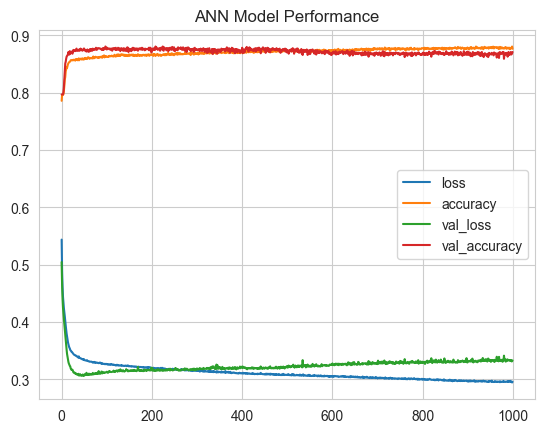

In [310]:
acc = pd.DataFrame(model.history.history)
acc.plot()
plt.title('ANN Model Performance');

In [311]:
y_pred = model.predict(X_test) # the y_pred is in probablity format

32/32 [==============================] - 0s 2ms/step


In [312]:
# robust scaller 
eval_metric(y_pred, y_test) 

Model Evaluation
-----------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.96      0.92       796
           1       0.74      0.49      0.59       204

    accuracy                           0.86      1000
   macro avg       0.81      0.72      0.75      1000
weighted avg       0.85      0.86      0.85      1000


[[761  35]
 [105  99]]

ROC-AUC score  0.7206621342004138


Due to the imbalanced nature of labels, class 1 performed worse than class 0 

#### testing with minmax and standard scaler using the above model after re-configuring X set scaling

In [89]:
y_pred = model.predict(X_test) 
# MinMax scaller results
eval_metric(y_pred, y_test) 

32/32 [==============================] - 0s 1ms/step
Model Evaluation
---------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.96      0.92       796
           1       0.75      0.48      0.58       204

    accuracy                           0.86      1000
   macro avg       0.81      0.72      0.75      1000
weighted avg       0.85      0.86      0.85      1000


[[764  32]
 [107  97]]

ROC-AUC score  0.7176445955266529


In [96]:
y_pred = model.predict(X_test) 
# Standard scaller results
eval_metric(y_pred, y_test) 

32/32 [==============================] - 0s 1ms/step
Model Evaluation
---------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.95      0.92       796
           1       0.73      0.50      0.59       204

    accuracy                           0.86      1000
   macro avg       0.81      0.73      0.76      1000
weighted avg       0.85      0.86      0.85      1000


[[759  37]
 [102 102]]

ROC-AUC score  0.7267587939698493


- The MinMax scaler is more effected by outliers
- The Robust scaler showed better results
- For the rest of the steps we will go with the robust scaler. 

## with class_weigth

Investigate how the "class_weight" hyper-parameter is used in a Neural Network.

### Create The Model

In [361]:
set_seed() 

model = Sequential(
    [
        Input(shape = X_train.shape[1]), # input layer
        Dense(units = 20, activation = 'relu'), # hidden layer (1)
        Dense(units = 10, activation = 'relu'), # hidden layer (2)
        Dense(units = 1, activation ='sigmoid'), # output layer - binary classification
    ]
)

In [362]:
optimizer = Adam()  # default alpha
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics=['Recall'])

In [363]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

In [364]:
class_weights = {0: class_weights[0], 1: class_weights[1]}

In [365]:
class_weights

{0: 0.6278777731268314, 1: 2.454991816693944}

In [366]:
model.fit(x = X_train, y = y_train, validation_split = 0.15, batch_size = 128, epochs = 1000, class_weight=class_weights)

Epoch 1/1000
60/60 [==============================] - 1s 5ms/step - loss: 0.7018 - recall: 0.3008 - val_loss: 0.6544 - val_recall: 0.4453
Epoch 2/1000
60/60 [==============================] - 0s 3ms/step - loss: 0.6581 - recall: 0.5632 - val_loss: 0.6125 - val_recall: 0.6058
Epoch 3/1000
60/60 [==============================] - 0s 3ms/step - loss: 0.6178 - recall: 0.6613 - val_loss: 0.5788 - val_recall: 0.7117
Epoch 4/1000
60/60 [==============================] - 0s 3ms/step - loss: 0.5841 - recall: 0.7319 - val_loss: 0.5407 - val_recall: 0.7044
Epoch 5/1000
60/60 [==============================] - 0s 3ms/step - loss: 0.5667 - recall: 0.7255 - val_loss: 0.5655 - val_recall: 0.7883
Epoch 6/1000
60/60 [==============================] - 0s 3ms/step - loss: 0.5552 - recall: 0.7377 - val_loss: 0.5263 - val_recall: 0.7482
Epoch 7/1000
60/60 [==============================] - 0s 3ms/step - loss: 0.5461 - recall: 0.7306 - val_loss: 0.5307 - val_recall: 0.7701
Epoch 8/1000
60/60 [==============

### Evaluate The Model

- Plot the model history to observe the changing of metrics
- Make prediction to see "confusion matrix" and "classification report"
- Check ROC (Receiver Operating Curve) and AUC (Area Under Curve) for the model

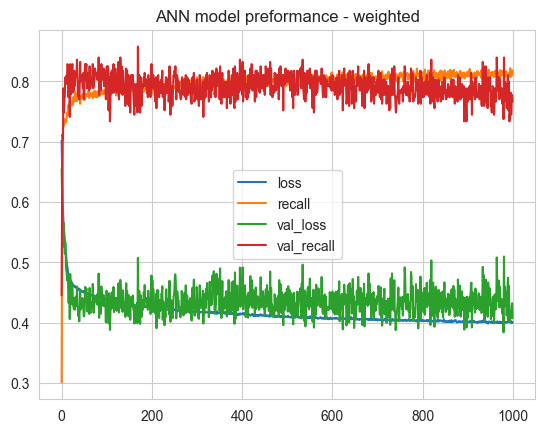

In [367]:
acc = pd.DataFrame(model.history.history)
acc.plot()
plt.title('ANN model preformance - weighted');

In [107]:
y_pred = model.predict(X_test) 
eval_metric(y_pred, y_test) 

32/32 [==============================] - 0s 1ms/step
Model Evaluation
---------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.73      0.82       796
           1       0.43      0.79      0.56       204

    accuracy                           0.74      1000
   macro avg       0.68      0.76      0.69      1000
weighted avg       0.83      0.74      0.77      1000


[[583 213]
 [ 42 162]]

ROC-AUC score  0.7632648536801654


## Implementation Different Methods to Develop The Model

- Implement the following methods on model creating with "class_weight" parameter
- Create and evaluate model for each method 

### Increase The Learning Rate and Observe The Results

In [108]:
set_seed() 

model = Sequential(
    [
        Input(shape = X_train.shape[1]), # input layer
        Dense(units = 20, activation = 'relu'), # hidden layer (1)
        Dense(units = 10, activation = 'relu'), # hidden layer (2)
        Dense(units = 1, activation ='sigmoid'), # output layer - binary classification
    ]
)

optimizer = Adam(learning_rate=0.003)  
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics=['Recall'])



In [109]:
model.fit(x = X_train, y = y_train, validation_split = 0.15, batch_size = 128, epochs = 200, class_weight=class_weights)

Epoch 1/200
60/60 [==============================] - 1s 5ms/step - loss: 0.6677 - recall: 0.5221 - val_loss: 0.6141 - val_recall: 0.7445
Epoch 2/200
60/60 [==============================] - 0s 2ms/step - loss: 0.5814 - recall: 0.7306 - val_loss: 0.5476 - val_recall: 0.7810
Epoch 3/200
60/60 [==============================] - 0s 2ms/step - loss: 0.5497 - recall: 0.7255 - val_loss: 0.5391 - val_recall: 0.7956
Epoch 4/200
60/60 [==============================] - 0s 2ms/step - loss: 0.5263 - recall: 0.7370 - val_loss: 0.4528 - val_recall: 0.7044
Epoch 5/200
60/60 [==============================] - 0s 2ms/step - loss: 0.5048 - recall: 0.7415 - val_loss: 0.4886 - val_recall: 0.8212
Epoch 6/200
60/60 [==============================] - 0s 2ms/step - loss: 0.4892 - recall: 0.7492 - val_loss: 0.4375 - val_recall: 0.7847
Epoch 7/200
60/60 [==============================] - 0s 2ms/step - loss: 0.4802 - recall: 0.7530 - val_loss: 0.5216 - val_recall: 0.8321
Epoch 8/200
60/60 [======================

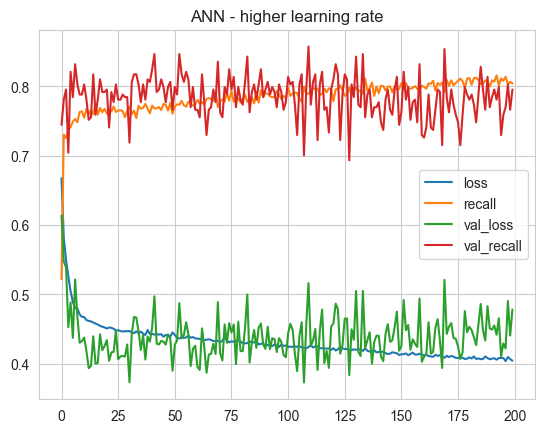

In [110]:
acc = pd.DataFrame(model.history.history)
acc.plot()
plt.title('ANN - higher learning rate');

In [111]:
y_pred = model.predict(X_test) 
eval_metric(y_pred, y_test) 

32/32 [==============================] - 0s 1ms/step
Model Evaluation
---------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.75      0.83       796
           1       0.44      0.77      0.56       204

    accuracy                           0.75      1000
   macro avg       0.68      0.76      0.69      1000
weighted avg       0.83      0.75      0.77      1000


[[595 201]
 [ 47 157]]

ROC-AUC score  0.7585476401615923


lower results than alpha = 0.001

### Add Dropout Layer

In [112]:
set_seed() 

model = Sequential(
    [
        Input(shape = X_train.shape[1]), # input layer
        Dense(units = 20, activation = 'relu'), # hidden layer (1)
        Dropout(0.2), # dropout layer
        Dense(units = 10, activation = 'relu'), # hidden layer (2)
        Dense(units = 1, activation ='sigmoid'), # output layer - binary classification
    ]
)

optimizer = Adam(learning_rate=0.001)  
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics=['Recall'])


model.fit(x = X_train, y = y_train, validation_split = 0.15, batch_size = 128, epochs = 200, class_weight=class_weights);

Epoch 1/200
60/60 [==============================] - 1s 5ms/step - loss: 0.7135 - recall: 0.2733 - val_loss: 0.6733 - val_recall: 0.5036
Epoch 2/200
60/60 [==============================] - 0s 3ms/step - loss: 0.6764 - recall: 0.5388 - val_loss: 0.6555 - val_recall: 0.6679
Epoch 3/200
60/60 [==============================] - 0s 3ms/step - loss: 0.6483 - recall: 0.6209 - val_loss: 0.6229 - val_recall: 0.7153
Epoch 4/200
60/60 [==============================] - 0s 3ms/step - loss: 0.6235 - recall: 0.6735 - val_loss: 0.5867 - val_recall: 0.7372
Epoch 5/200
60/60 [==============================] - 0s 3ms/step - loss: 0.6077 - recall: 0.6928 - val_loss: 0.5882 - val_recall: 0.8029
Epoch 6/200
60/60 [==============================] - 0s 3ms/step - loss: 0.5908 - recall: 0.7191 - val_loss: 0.5635 - val_recall: 0.7847
Epoch 7/200
60/60 [==============================] - 0s 3ms/step - loss: 0.5816 - recall: 0.7165 - val_loss: 0.5688 - val_recall: 0.8139
Epoch 8/200
60/60 [======================

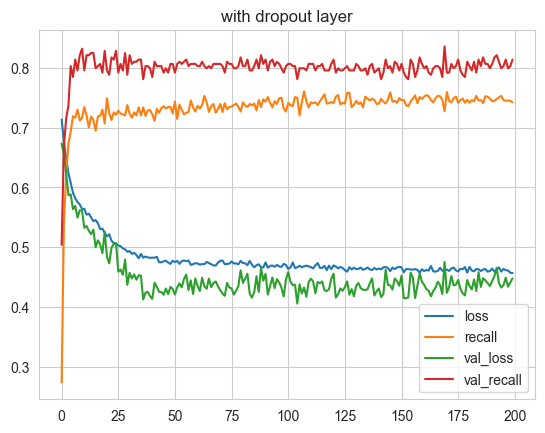

In [113]:
acc = pd.DataFrame(model.history.history)
acc.plot()
plt.title('with dropout layer');

In [114]:
y_pred = model.predict(X_test) 
eval_metric(y_pred, y_test) 

32/32 [==============================] - 0s 1ms/step
Model Evaluation
---------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.77      0.84       796
           1       0.47      0.78      0.59       204

    accuracy                           0.77      1000
   macro avg       0.70      0.78      0.72      1000
weighted avg       0.84      0.77      0.79      1000


[[614 182]
 [ 44 160]]

ROC-AUC score  0.777835254704897


Slightly better results

### Add Early Stop

#### Monitor the "val_loss" as metric

In [195]:
set_seed() 

model = Sequential(
    [
        Input(shape = X_train.shape[1]), # input layer
        Dense(units = 20, activation = 'relu'), # hidden layer (1)
        Dropout(0.2), # dropout layer
        Dense(units = 10, activation = 'relu'), # hidden layer (2)
        Dropout(0.2), # dropout layer
        Dense(units = 1, activation ='sigmoid'), # output layer - binary classification
    ]
)

optimizer = Adam(learning_rate=0.001)  
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics=['Recall'])

early_stop = EarlyStopping(
    monitor='val_loss', mode='auto', verbose=1, patience=20, restore_best_weights=True)

model.fit(x = X_train, y = y_train, validation_split = 0.15,
           batch_size = 128, epochs = 200, class_weight=class_weights,
           callbacks = [early_stop])

Epoch 1/200
60/60 [==============================] - 2s 10ms/step - loss: 0.7250 - recall: 0.2874 - val_loss: 0.6716 - val_recall: 0.4781
Epoch 2/200
60/60 [==============================] - 0s 5ms/step - loss: 0.6867 - recall: 0.5157 - val_loss: 0.6574 - val_recall: 0.5876
Epoch 3/200
60/60 [==============================] - 0s 4ms/step - loss: 0.6671 - recall: 0.5593 - val_loss: 0.6345 - val_recall: 0.6423
Epoch 4/200
60/60 [==============================] - 0s 4ms/step - loss: 0.6490 - recall: 0.6183 - val_loss: 0.6063 - val_recall: 0.6898
Epoch 5/200
60/60 [==============================] - 0s 4ms/step - loss: 0.6323 - recall: 0.6402 - val_loss: 0.5978 - val_recall: 0.7555
Epoch 6/200
60/60 [==============================] - 0s 4ms/step - loss: 0.6164 - recall: 0.6767 - val_loss: 0.5841 - val_recall: 0.7847
Epoch 7/200
60/60 [==============================] - 0s 4ms/step - loss: 0.6049 - recall: 0.7030 - val_loss: 0.5830 - val_recall: 0.8102
Epoch 8/200
60/60 [=====================

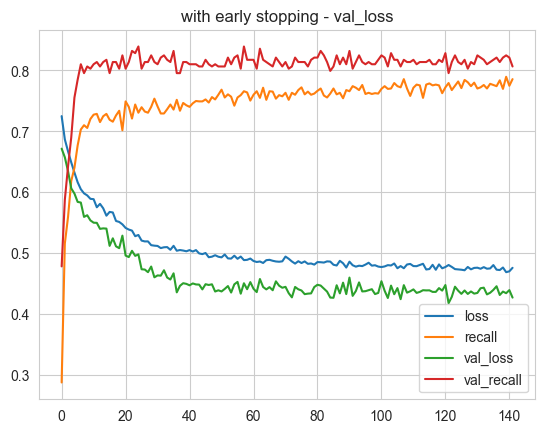

In [196]:
acc = pd.DataFrame(model.history.history)
acc.plot()
plt.title('with early stopping - val_loss');

In [197]:
y_pred = model.predict(X_test) 
eval_metric(y_pred, y_test) 

32/32 [==============================] - 0s 2ms/step
Model Evaluation
---------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.79      0.85       796
           1       0.48      0.77      0.59       204

    accuracy                           0.78      1000
   macro avg       0.71      0.78      0.72      1000
weighted avg       0.84      0.78      0.80      1000


[[627 169]
 [ 47 157]]

ROC-AUC score  0.778648142674155


#### Monitor the "val_recall" as metric

In [129]:
set_seed() 

model = Sequential(
    [
        Input(shape = X_train.shape[1]), # input layer
        Dense(units = 20, activation = 'relu'), # hidden layer (1)
        Dropout(0.2), # dropout layer
        Dense(units = 10, activation = 'relu'), # hidden layer (2)
        Dense(units = 1, activation ='sigmoid'), # output layer - binary classification
    ]
)

optimizer = Adam(learning_rate=0.001)  
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics=['Recall'])

early_stop = EarlyStopping(
    monitor='val_recall', mode='auto', verbose=1, patience=20, restore_best_weights=True)

model.fit(x = X_train, y = y_train, validation_split = 0.15,
           batch_size = 128, epochs = 200, class_weight=class_weights,
           callbacks = [early_stop])

Epoch 1/200
60/60 [==============================] - 1s 5ms/step - loss: 0.7135 - recall: 0.2733 - val_loss: 0.6733 - val_recall: 0.5036
Epoch 2/200
60/60 [==============================] - 0s 3ms/step - loss: 0.6764 - recall: 0.5388 - val_loss: 0.6555 - val_recall: 0.6679
Epoch 3/200
60/60 [==============================] - 0s 2ms/step - loss: 0.6483 - recall: 0.6209 - val_loss: 0.6229 - val_recall: 0.7153
Epoch 4/200
60/60 [==============================] - 0s 2ms/step - loss: 0.6235 - recall: 0.6735 - val_loss: 0.5867 - val_recall: 0.7372
Epoch 5/200
60/60 [==============================] - 0s 2ms/step - loss: 0.6077 - recall: 0.6928 - val_loss: 0.5882 - val_recall: 0.8029
Epoch 6/200
60/60 [==============================] - 0s 3ms/step - loss: 0.5908 - recall: 0.7191 - val_loss: 0.5635 - val_recall: 0.7847
Epoch 7/200
60/60 [==============================] - 0s 3ms/step - loss: 0.5816 - recall: 0.7165 - val_loss: 0.5688 - val_recall: 0.8139
Epoch 8/200
60/60 [======================

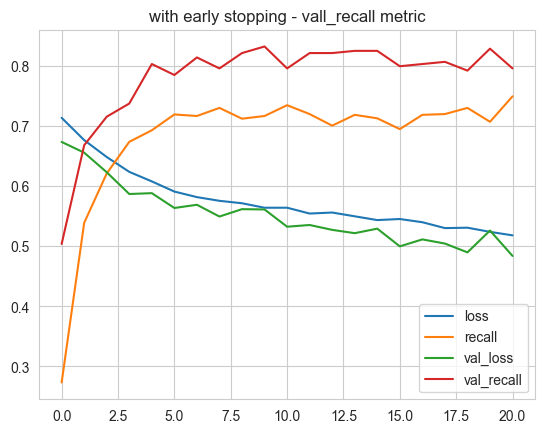

In [130]:
acc = pd.DataFrame(model.history.history)
acc.plot()
plt.title('with early stopping - vall_recall metric');

In [131]:
y_pred = model.predict(X_test) 
eval_metric(y_pred, y_test) 

32/32 [==============================] - 0s 1ms/step
Model Evaluation
---------------------------------------
              precision    recall  f1-score   support

           0       0.80      0.55      0.65       796
           1       0.21      0.47      0.29       204

    accuracy                           0.53      1000
   macro avg       0.51      0.51      0.47      1000
weighted avg       0.68      0.53      0.58      1000


[[438 358]
 [108  96]]

ROC-AUC score  0.5104197457877624


## Optuna

In [229]:
early_stop = EarlyStopping(monitor='val_loss', mode='auto', verbose=0, patience=20, restore_best_weights=True)

In [263]:
recall_c1 = make_scorer(recall_score, average=None, labels=[1])

In [274]:
def objective(trial, early_stop=early_stop):

    learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 1e-2)
    #dropout = trial.suggest_uniform('dropout_rate', 0.0, 1.0)
    #w0 = trial.suggest_loguniform('w0', 0.01, 5)
    w1 = trial.suggest_loguniform('w1', 2, 4)
    #optimizer = trial.suggest_categorical('optimizer', [Adam, Adadelta, RMSprop, Nadam])
    #units_layer1 = trial.suggest_int('units_layer1', 16, 20)
    #units_layer2 = trial.suggest_int('units_layer2', 6, 12)
    
    set_seed() 

    model = Sequential(
         [
        Input(shape = X_train.shape[1]), 
        Dense(units = 20, activation = 'relu'), 
        Dropout(0.2), 
        Dense(units = 10, activation = 'relu'),
        Dropout(0.2), 
        Dense(units = 1, activation ='sigmoid'), 
            ]
        )
    optimizer = Adam(learning_rate)  
    model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics=['Recall'])

    model.fit(x=X_train, y=y_train, validation_split=0.15,
              batch_size=128, epochs=1000, class_weight={0: class_weights[0], 1: w1}, verbose = 0, #logging off
              callbacks=[early_stop])

    # scoring for f1 
    y_pred = model.predict(X_test) 
    y_pred = np.round(y_pred).flatten() 
    recall = recall_score(y_pred=y_pred, y_true=y_test, labels=[1])

    return recall


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

trial = study.best_trial

print('Best trial: {}'.format(trial.number))
print('Recall score: {}'.format(trial.value))
print('Best hyperparameters: {}'.format(study.best_params))

[I 2023-10-26 19:35:30,291] A new study created in memory with name: no-name-77d6a375-716e-4778-98c4-5ded99d68ee3


32/32 [==============================] - 0s 1ms/step


[I 2023-10-26 19:35:38,965] Trial 0 finished with value: 0.7598039215686274 and parameters: {'learning_rate': 0.006675595056969393, 'w1': 2.1708155682532237}. Best is trial 0 with value: 0.7598039215686274.


32/32 [==============================] - 0s 1ms/step


[I 2023-10-26 19:35:47,906] Trial 1 finished with value: 0.5490196078431373 and parameters: {'learning_rate': 0.0018197855618477458, 'w1': 1.1063676144665378}. Best is trial 0 with value: 0.7598039215686274.


32/32 [==============================] - 0s 1ms/step


[I 2023-10-26 19:35:56,101] Trial 2 finished with value: 0.7254901960784313 and parameters: {'learning_rate': 0.0014823262294093849, 'w1': 2.3319754727681747}. Best is trial 0 with value: 0.7598039215686274.


32/32 [==============================] - 0s 2ms/step


[I 2023-10-26 19:36:05,000] Trial 3 finished with value: 0.7205882352941176 and parameters: {'learning_rate': 0.009888877543012476, 'w1': 2.110972480999841}. Best is trial 0 with value: 0.7598039215686274.


32/32 [==============================] - 0s 2ms/step


[I 2023-10-26 19:36:18,867] Trial 4 finished with value: 0.7941176470588235 and parameters: {'learning_rate': 0.001701118508811007, 'w1': 2.869559124094812}. Best is trial 4 with value: 0.7941176470588235.


32/32 [==============================] - 0s 1ms/step


[I 2023-10-26 19:36:31,834] Trial 5 finished with value: 0.5343137254901961 and parameters: {'learning_rate': 0.008569407406942882, 'w1': 1.1307289990800866}. Best is trial 4 with value: 0.7941176470588235.


32/32 [==============================] - 0s 1ms/step


[I 2023-10-26 19:36:42,658] Trial 6 finished with value: 0.6323529411764706 and parameters: {'learning_rate': 0.0018166352725014184, 'w1': 1.516414403726155}. Best is trial 4 with value: 0.7941176470588235.


32/32 [==============================] - 0s 1ms/step


[I 2023-10-26 19:36:50,083] Trial 7 finished with value: 0.6715686274509803 and parameters: {'learning_rate': 0.006670885665446938, 'w1': 1.8581155187540968}. Best is trial 4 with value: 0.7941176470588235.


32/32 [==============================] - 0s 1ms/step


[I 2023-10-26 19:37:01,041] Trial 8 finished with value: 0.6078431372549019 and parameters: {'learning_rate': 0.002929710436865548, 'w1': 1.2984303878546295}. Best is trial 4 with value: 0.7941176470588235.


32/32 [==============================] - 0s 1ms/step


[I 2023-10-26 19:37:15,250] Trial 9 finished with value: 0.7107843137254902 and parameters: {'learning_rate': 0.0011967515670967099, 'w1': 1.918747235866497}. Best is trial 4 with value: 0.7941176470588235.


32/32 [==============================] - 0s 1ms/step


[I 2023-10-26 19:37:30,664] Trial 10 finished with value: 0.8088235294117647 and parameters: {'learning_rate': 0.0010264275265984002, 'w1': 2.998497789915454}. Best is trial 10 with value: 0.8088235294117647.


32/32 [==============================] - 0s 1ms/step


[I 2023-10-26 19:37:45,410] Trial 11 finished with value: 0.803921568627451 and parameters: {'learning_rate': 0.0010462999347439963, 'w1': 2.91461140143885}. Best is trial 10 with value: 0.8088235294117647.


32/32 [==============================] - 0s 1ms/step


[I 2023-10-26 19:38:01,289] Trial 12 finished with value: 0.8088235294117647 and parameters: {'learning_rate': 0.0010247763277133652, 'w1': 2.9692608570928893}. Best is trial 10 with value: 0.8088235294117647.


32/32 [==============================] - 0s 1ms/step


[I 2023-10-26 19:38:24,535] Trial 13 finished with value: 0.7696078431372549 and parameters: {'learning_rate': 0.0010618046692497795, 'w1': 2.584980964460086}. Best is trial 10 with value: 0.8088235294117647.


32/32 [==============================] - 0s 1ms/step


[I 2023-10-26 19:38:34,263] Trial 14 finished with value: 0.8088235294117647 and parameters: {'learning_rate': 0.0024377531113446292, 'w1': 2.9811662031080104}. Best is trial 10 with value: 0.8088235294117647.


32/32 [==============================] - 0s 1ms/step


[I 2023-10-26 19:38:44,806] Trial 15 finished with value: 0.7303921568627451 and parameters: {'learning_rate': 0.001352476669127572, 'w1': 2.4498948315065046}. Best is trial 10 with value: 0.8088235294117647.


32/32 [==============================] - 0s 1ms/step


[I 2023-10-26 19:39:07,928] Trial 16 finished with value: 0.7745098039215687 and parameters: {'learning_rate': 0.001019671340153834, 'w1': 2.541565587837047}. Best is trial 10 with value: 0.8088235294117647.


32/32 [==============================] - 0s 1ms/step


[I 2023-10-26 19:39:17,919] Trial 17 finished with value: 0.6519607843137255 and parameters: {'learning_rate': 0.0022478766197283058, 'w1': 1.6174166560152352}. Best is trial 10 with value: 0.8088235294117647.


32/32 [==============================] - 0s 1ms/step


[I 2023-10-26 19:39:27,450] Trial 18 finished with value: 0.7549019607843137 and parameters: {'learning_rate': 0.0014660360597133755, 'w1': 2.6740646718734076}. Best is trial 10 with value: 0.8088235294117647.


32/32 [==============================] - 0s 2ms/step


[I 2023-10-26 19:39:34,650] Trial 19 finished with value: 0.7107843137254902 and parameters: {'learning_rate': 0.0036752408605307593, 'w1': 2.2640551225804586}. Best is trial 10 with value: 0.8088235294117647.


Best trial: 10
Recall score: 0.8088235294117647
Best hyperparameters: {'learning_rate': 0.0010264275265984002, 'w1': 2.998497789915454}


In [275]:
optuna.visualization.plot_optimization_history(study)

In [276]:
optuna.visualization.plot_slice(study)

In [277]:
learning_rate = study.best_params['learning_rate']
#w0 = study.best_params['w0']
w1 = study.best_params['w1']

model = Sequential(
         [
        Input(shape = X_train.shape[1]), 
        Dense(units = 20, activation = 'relu'), 
        Dropout(0.2), 
        Dense(units = 10, activation = 'relu'),
        Dropout(0.2), 
        Dense(units = 1, activation ='sigmoid'), 
            ]
        )
optimizer = Adam(learning_rate)  
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics=['Recall'])

model.fit(x=X_train, y=y_train, validation_split=0.15,
              batch_size=128, epochs=1000, class_weight={0: class_weights[0], 1: w1}, verbose = 0, #logging off
              callbacks=[early_stop])


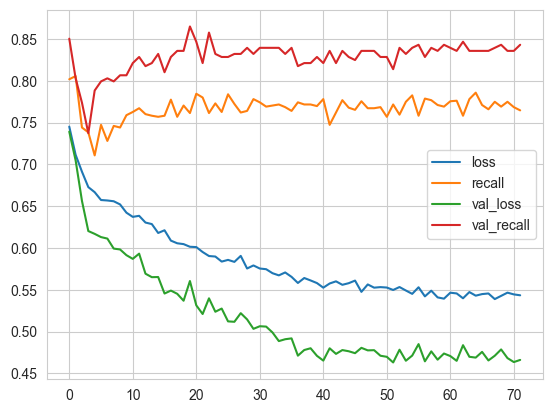

In [278]:
acc = pd.DataFrame(model.history.history)
acc.plot();

In [279]:
y_pred = model.predict(X_test) 
eval_metric(y_pred, y_test) 

32/32 [==============================] - 0s 3ms/step
Model Evaluation
---------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.77      0.84       796
           1       0.46      0.77      0.57       204

    accuracy                           0.77      1000
   macro avg       0.69      0.77      0.71      1000
weighted avg       0.83      0.77      0.78      1000


[[609 187]
 [ 47 157]]

ROC-AUC score  0.7673416100108384


def objective(trial, early_stop=early_stop):

    learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 1e-2)
    #dropout = trial.suggest_uniform('dropout_rate', 0.0, 1.0)
    #w0 = trial.suggest_loguniform('w0', 0.01, 5)
    w1 = trial.suggest_loguniform('w1', 3, 5)
    #optimizer = trial.suggest_categorical('optimizer', [Adam, Adadelta, RMSprop, Nadam])
    #units_layer1 = trial.suggest_int('units_layer1', 16, 20)
    #units_layer2 = trial.suggest_int('units_layer2', 6, 12)
    
    set_seed() 

    model = Sequential(
         [
        Input(shape = X_train.shape[1]), 
        Dense(units = 20, activation = 'relu'), 
        Dropout(0.2), 
        Dense(units = 10, activation = 'relu'),
        Dropout(0.2), 
        Dense(units = 1, activation ='sigmoid'), 
            ]
        )
    optimizer = Adam(learning_rate)  
    model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics=['Recall'])

    model.fit(x=X_train, y=y_train, validation_split=0.15,
              batch_size=128, epochs=1000, class_weight={0: class_weights[0], 1: w1}, verbose = 0, #logging off
              callbacks=[early_stop])

    # scoring for f1 
    y_pred = model.predict(X_test) 
    y_pred = np.round(y_pred).flatten() 
    f1 = recall_score(y_pred, y_test)

    return f1


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

trial = study.best_trial

print('Best trial: {}'.format(trial.number))
print('F1 score: {}'.format(trial.value))
print('Best hyperparameters: {}'.format(study.best_params))

Model Evaluation
---------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.77      0.84       796
           1       0.46      0.77      0.58       204

    accuracy                           0.77      1000
   macro avg       0.69      0.77      0.71      1000
weighted avg       0.83      0.77      0.79      1000


[[610 186]
 [ 46 158]]

ROC-AUC score  0.7704207311065129


with w1 and custom recall
32/32 [==============================] - 0s 2ms/step
Model Evaluation
---------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.64      0.76       796
           1       0.38      0.86      0.52       204

    accuracy                           0.68      1000
   macro avg       0.66      0.75      0.64      1000
weighted avg       0.83      0.68      0.71      1000


[[508 288]
 [ 29 175]]

ROC-AUC score  0.7480170460143856

In [417]:
learning_rate

0.0010264275265984002

In [418]:
def objective(trial, early_stop=early_stop):


    optimizer = trial.suggest_categorical('optimizer', [Adam, Adadelta, RMSprop, Nadam])
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 1.0)
    units_layer1 = trial.suggest_int('units_layer1', 16, 64)
    units_layer2 = trial.suggest_int('units_layer2', 8, 32)
    
    set_seed() 

    model = Sequential(
         [
        Input(shape = X_train.shape[1]), 
        Dense(units = units_layer1, activation = 'relu'), 
        Dropout(dropout_rate), 
        Dense(units = units_layer2, activation = 'relu'),
        Dropout(dropout_rate), 
        Dense(units = 1, activation ='sigmoid'), 
            ]
        )

    model.compile(optimizer = optimizer(learning_rate), loss = 'binary_crossentropy', metrics=['Recall'])

    model.fit(x=X_train, y=y_train, validation_split=0.15,
              batch_size=128, epochs=1000, class_weight={0: class_weights[0], 1: w1}, verbose = 0, #logging off
              callbacks=[early_stop])

    # scoring for recall 
    y_pred = model.predict(X_test) 
    #y_pred = np.round(y_pred).flatten() 
    recall = roc_auc_score(y_score=y_pred, y_true=y_test)

    return recall


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=25)

trial = study.best_trial

print('Best trial: {}'.format(trial.number))
print('Recall score: {}'.format(trial.value))
print('Best hyperparameters: {}'.format(study.best_params))

[I 2023-10-27 04:49:35,193] A new study created in memory with name: no-name-eeffac31-1320-4a9d-9302-e2bcc5ca089b


32/32 [==============================] - 0s 1ms/step


[I 2023-10-27 04:49:49,318] Trial 0 finished with value: 0.8555645876441029 and parameters: {'optimizer': <class 'keras.src.optimizers.rmsprop.RMSprop'>, 'dropout_rate': 0.385128879974566, 'units_layer1': 32, 'units_layer2': 8}. Best is trial 0 with value: 0.8555645876441029.


32/32 [==============================] - 0s 1ms/step


[I 2023-10-27 04:50:02,250] Trial 1 finished with value: 0.7898068775248792 and parameters: {'optimizer': <class 'keras.src.optimizers.rmsprop.RMSprop'>, 'dropout_rate': 0.6916553321372729, 'units_layer1': 17, 'units_layer2': 14}. Best is trial 0 with value: 0.8555645876441029.


32/32 [==============================] - 0s 2ms/step


[I 2023-10-27 04:50:07,091] Trial 2 finished with value: 0.6007550004926593 and parameters: {'optimizer': <class 'keras.src.optimizers.nadam.Nadam'>, 'dropout_rate': 0.8340218713928444, 'units_layer1': 41, 'units_layer2': 19}. Best is trial 0 with value: 0.8555645876441029.


32/32 [==============================] - 0s 2ms/step


[I 2023-10-27 04:50:17,593] Trial 3 finished with value: 0.8561434624100897 and parameters: {'optimizer': <class 'keras.src.optimizers.rmsprop.RMSprop'>, 'dropout_rate': 0.27629769648017866, 'units_layer1': 33, 'units_layer2': 21}. Best is trial 3 with value: 0.8561434624100897.


32/32 [==============================] - 0s 1ms/step


[I 2023-10-27 04:50:39,299] Trial 4 finished with value: 0.8593395901073998 and parameters: {'optimizer': <class 'keras.src.optimizers.rmsprop.RMSprop'>, 'dropout_rate': 0.6329894664418793, 'units_layer1': 43, 'units_layer2': 19}. Best is trial 4 with value: 0.8593395901073998.


32/32 [==============================] - 0s 2ms/step


[I 2023-10-27 04:53:19,065] Trial 5 finished with value: 0.7477460833579664 and parameters: {'optimizer': <class 'keras.src.optimizers.adadelta.Adadelta'>, 'dropout_rate': 0.2801464569615842, 'units_layer1': 29, 'units_layer2': 30}. Best is trial 4 with value: 0.8593395901073998.


32/32 [==============================] - 0s 1ms/step


[I 2023-10-27 04:53:36,580] Trial 6 finished with value: 0.8487782047492364 and parameters: {'optimizer': <class 'keras.src.optimizers.adam.Adam'>, 'dropout_rate': 0.6600404144900518, 'units_layer1': 30, 'units_layer2': 30}. Best is trial 4 with value: 0.8593395901073998.


32/32 [==============================] - 0s 2ms/step


[I 2023-10-27 04:53:40,929] Trial 7 finished with value: 0.49625578874765985 and parameters: {'optimizer': <class 'keras.src.optimizers.adam.Adam'>, 'dropout_rate': 0.9949148849164914, 'units_layer1': 27, 'units_layer2': 9}. Best is trial 4 with value: 0.8593395901073998.


32/32 [==============================] - 0s 2ms/step


[I 2023-10-27 04:54:14,278] Trial 8 finished with value: 0.852867277564292 and parameters: {'optimizer': <class 'keras.src.optimizers.nadam.Nadam'>, 'dropout_rate': 0.5949578488063108, 'units_layer1': 47, 'units_layer2': 9}. Best is trial 4 with value: 0.8593395901073998.


32/32 [==============================] - 0s 1ms/step


[I 2023-10-27 04:57:11,929] Trial 9 finished with value: 0.7198677209577299 and parameters: {'optimizer': <class 'keras.src.optimizers.adadelta.Adadelta'>, 'dropout_rate': 0.6381952290983753, 'units_layer1': 44, 'units_layer2': 30}. Best is trial 4 with value: 0.8593395901073998.


32/32 [==============================] - 0s 2ms/step


[I 2023-10-27 04:57:22,862] Trial 10 finished with value: 0.8482978618583112 and parameters: {'optimizer': <class 'keras.src.optimizers.rmsprop.RMSprop'>, 'dropout_rate': 0.4247685704109242, 'units_layer1': 62, 'units_layer2': 23}. Best is trial 4 with value: 0.8593395901073998.


32/32 [==============================] - 0s 2ms/step


[I 2023-10-27 04:57:34,483] Trial 11 finished with value: 0.8562727854961081 and parameters: {'optimizer': <class 'keras.src.optimizers.rmsprop.RMSprop'>, 'dropout_rate': 0.20032120170949047, 'units_layer1': 50, 'units_layer2': 22}. Best is trial 4 with value: 0.8593395901073998.


32/32 [==============================] - 0s 1ms/step


[I 2023-10-27 04:57:45,443] Trial 12 finished with value: 0.8593272736230171 and parameters: {'optimizer': <class 'keras.src.optimizers.rmsprop.RMSprop'>, 'dropout_rate': 0.12036242739107077, 'units_layer1': 54, 'units_layer2': 24}. Best is trial 4 with value: 0.8593395901073998.


32/32 [==============================] - 0s 1ms/step


[I 2023-10-27 04:57:56,063] Trial 13 finished with value: 0.8563651591289784 and parameters: {'optimizer': <class 'keras.src.optimizers.rmsprop.RMSprop'>, 'dropout_rate': 0.1333419571688352, 'units_layer1': 56, 'units_layer2': 26}. Best is trial 4 with value: 0.8593395901073998.


32/32 [==============================] - 0s 2ms/step


[I 2023-10-27 04:58:10,653] Trial 14 finished with value: 0.8492616267612574 and parameters: {'optimizer': <class 'keras.src.optimizers.rmsprop.RMSprop'>, 'dropout_rate': 0.47739949876513854, 'units_layer1': 55, 'units_layer2': 17}. Best is trial 4 with value: 0.8593395901073998.


32/32 [==============================] - 0s 1ms/step


[I 2023-10-27 04:58:21,519] Trial 15 finished with value: 0.8602941176470588 and parameters: {'optimizer': <class 'keras.src.optimizers.rmsprop.RMSprop'>, 'dropout_rate': 0.11053292261478487, 'units_layer1': 64, 'units_layer2': 26}. Best is trial 15 with value: 0.8602941176470588.


32/32 [==============================] - 0s 1ms/step


[I 2023-10-27 04:58:34,245] Trial 16 finished with value: 0.8583204010247316 and parameters: {'optimizer': <class 'keras.src.optimizers.nadam.Nadam'>, 'dropout_rate': 0.5220697878078514, 'units_layer1': 61, 'units_layer2': 26}. Best is trial 15 with value: 0.8602941176470588.


32/32 [==============================] - 0s 1ms/step


[I 2023-10-27 04:58:46,947] Trial 17 finished with value: 0.8561095920780373 and parameters: {'optimizer': <class 'keras.src.optimizers.adam.Adam'>, 'dropout_rate': 0.36359669531896777, 'units_layer1': 40, 'units_layer2': 15}. Best is trial 15 with value: 0.8602941176470588.


32/32 [==============================] - 0s 2ms/step


[I 2023-10-27 04:58:52,036] Trial 18 finished with value: 0.4803983151049364 and parameters: {'optimizer': <class 'keras.src.optimizers.adadelta.Adadelta'>, 'dropout_rate': 0.5183401767694544, 'units_layer1': 64, 'units_layer2': 27}. Best is trial 15 with value: 0.8602941176470588.


32/32 [==============================] - 0s 2ms/step


[I 2023-10-27 04:59:07,217] Trial 19 finished with value: 0.8557554931520346 and parameters: {'optimizer': <class 'keras.src.optimizers.rmsprop.RMSprop'>, 'dropout_rate': 0.29840950394462684, 'units_layer1': 20, 'units_layer2': 18}. Best is trial 15 with value: 0.8602941176470588.


32/32 [==============================] - 0s 2ms/step


[I 2023-10-27 04:59:22,037] Trial 20 finished with value: 0.7982313528426447 and parameters: {'optimizer': <class 'keras.src.optimizers.rmsprop.RMSprop'>, 'dropout_rate': 0.7362296294238589, 'units_layer1': 37, 'units_layer2': 12}. Best is trial 15 with value: 0.8602941176470588.


32/32 [==============================] - 0s 1ms/step


[I 2023-10-27 04:59:32,471] Trial 21 finished with value: 0.8622462804217164 and parameters: {'optimizer': <class 'keras.src.optimizers.rmsprop.RMSprop'>, 'dropout_rate': 0.15453170060846147, 'units_layer1': 55, 'units_layer2': 24}. Best is trial 21 with value: 0.8622462804217164.


32/32 [==============================] - 0s 1ms/step


[I 2023-10-27 04:59:43,062] Trial 22 finished with value: 0.8582803724504877 and parameters: {'optimizer': <class 'keras.src.optimizers.rmsprop.RMSprop'>, 'dropout_rate': 0.1975783246678245, 'units_layer1': 58, 'units_layer2': 24}. Best is trial 21 with value: 0.8622462804217164.


32/32 [==============================] - 0s 1ms/step


[I 2023-10-27 04:59:53,634] Trial 23 finished with value: 0.8571903635826189 and parameters: {'optimizer': <class 'keras.src.optimizers.rmsprop.RMSprop'>, 'dropout_rate': 0.10900670251010479, 'units_layer1': 51, 'units_layer2': 32}. Best is trial 21 with value: 0.8622462804217164.


32/32 [==============================] - 0s 1ms/step


[I 2023-10-27 05:00:05,076] Trial 24 finished with value: 0.856944033894965 and parameters: {'optimizer': <class 'keras.src.optimizers.rmsprop.RMSprop'>, 'dropout_rate': 0.20994248244558358, 'units_layer1': 60, 'units_layer2': 21}. Best is trial 21 with value: 0.8622462804217164.


Best trial: 21
Recall score: 0.8622462804217164
Best hyperparameters: {'optimizer': <class 'keras.src.optimizers.rmsprop.RMSprop'>, 'dropout_rate': 0.15453170060846147, 'units_layer1': 55, 'units_layer2': 24}


In [419]:
optuna.visualization.plot_optimization_history(study)

In [420]:
study.best_params

{'optimizer': keras.src.optimizers.rmsprop.RMSprop,
 'dropout_rate': 0.15453170060846147,
 'units_layer1': 55,
 'units_layer2': 24}

In [421]:
d = study.best_params['dropout_rate']

In [422]:
set_seed() 

model = Sequential(
         [
        Input(shape = X_train.shape[1]), 
        Dense(units = 55, activation = 'relu'), 
        Dropout(d), 
        Dense(units = 24, activation = 'relu'),
        Dropout(d), 
        Dense(units = 1, activation ='sigmoid'), 
            ]
        )

model.compile(optimizer = RMSprop(learning_rate), loss = 'binary_crossentropy', metrics=['Recall'])

model.fit(x=X_train, y=y_train, validation_split=0.15,
              batch_size=128, epochs=1000, class_weight={0: class_weights[0], 1: w1}, verbose = 0, #logging off
              callbacks=[early_stop])

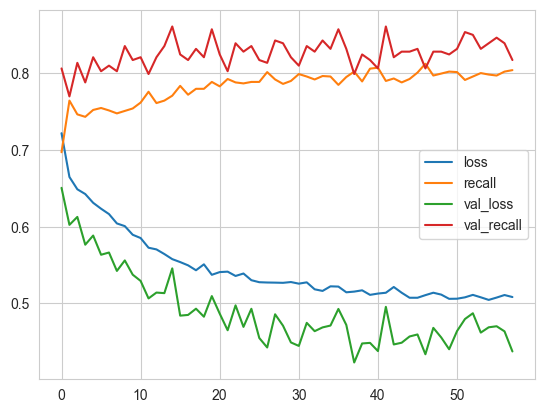

In [423]:
acc = pd.DataFrame(model.history.history)
acc.plot();

In [424]:
y_pred = model.predict(X_test) 
eval_metric(y_pred, y_test) 

32/32 [==============================] - 0s 1ms/step
Model Evaluation
-----------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.78      0.85       796
           1       0.47      0.76      0.59       204

    accuracy                           0.78      1000
   macro avg       0.70      0.77      0.72      1000
weighted avg       0.84      0.78      0.80      1000


[[623 173]
 [ 48 156]]

ROC-AUC score  0.7736845994679278


 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


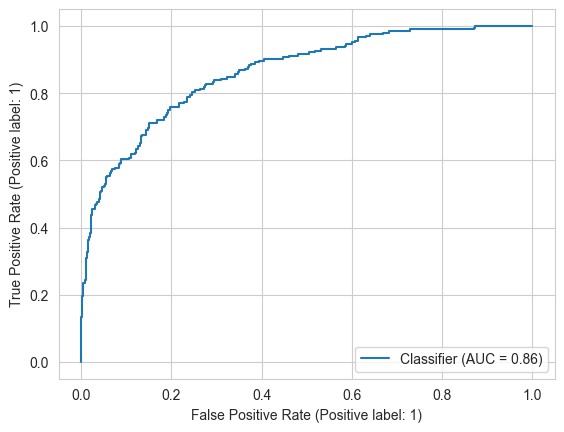

In [425]:
y_pred_proba = model.predict(X_test)
RocCurveDisplay.from_predictions(y_test, y_pred_proba)

In [426]:
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

  1/282 [..............................] - ETA: 8s

32/32 [==============================] - 0s 1ms/step


In [429]:
auc_class_0 = roc_auc_score(1 - y_test, 1 - y_pred)
auc_class_1 = roc_auc_score(y_test, y_pred)

In [430]:
auc_class_0

0.8622462804217165

In [431]:
auc_class_1

0.8622462804217164

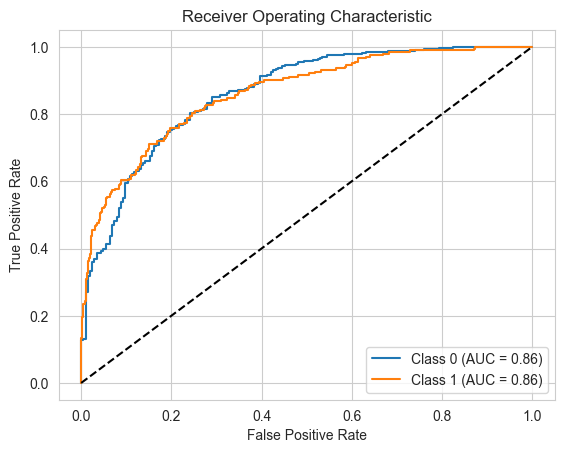

In [432]:
fpr_class_0, tpr_class_0, _ = roc_curve(1 - y_test, 1 - y_pred)
auc_class_0 = roc_auc_score(1 - y_test, 1 - y_pred)

# Calculate the ROC curve for class 1
fpr_class_1, tpr_class_1, _ = roc_curve(y_test, y_pred)
auc_class_1 = roc_auc_score(y_test, y_pred)

# Plot the ROC curves
plt.plot(fpr_class_0, tpr_class_0, label='Class 0 (AUC = {:.2f})'.format(auc_class_0))
plt.plot(fpr_class_1, tpr_class_1, label='Class 1 (AUC = {:.2f})'.format(auc_class_1))
plt.plot([0, 1], [0, 1], 'k--')  # Identity line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [446]:
set_seed() 

model = Sequential(
         [
        Input(shape = X_train.shape[1]), 
        Dense(units = 55, activation = 'relu'), 
        Dropout(d), 
        Dense(units = 24, activation = 'relu'),
        Dropout(d), 
        Dense(units = 1, activation ='sigmoid'), 
            ]
        )

model.compile(optimizer = RMSprop(learning_rate), loss = 'binary_crossentropy', metrics=['Recall'])

model.fit(x=X_train, y=y_train, validation_split=0.15,
              batch_size=128, epochs=1000, class_weight={0: class_weights[0], 1: w1}, verbose = 0, #logging off
              callbacks=[early_stop])

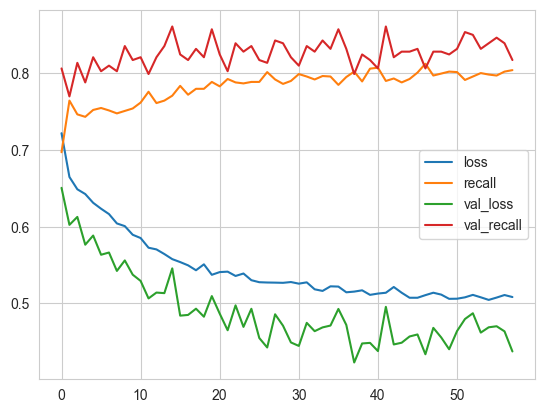

In [447]:
acc = pd.DataFrame(model.history.history)
acc.plot();

In [448]:
y_pred = model.predict(X_test) 
eval_metric(y_pred, y_test) 

32/32 [==============================] - 0s 1ms/step
Model Evaluation
-----------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.78      0.85       796
           1       0.47      0.76      0.59       204

    accuracy                           0.78      1000
   macro avg       0.70      0.77      0.72      1000
weighted avg       0.84      0.78      0.80      1000


[[623 173]
 [ 48 156]]

ROC-AUC score  0.7736845994679278


In [456]:
y_pred = model.predict(X_test) > 0.5
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

 1/32 [..............................] - ETA: 1s

32/32 [==============================] - 0s 2ms/step
[[623 173]
 [ 48 156]]
              precision    recall  f1-score   support

           0       0.93      0.78      0.85       796
           1       0.47      0.76      0.59       204

    accuracy                           0.78      1000
   macro avg       0.70      0.77      0.72      1000
weighted avg       0.84      0.78      0.80      1000



### Evaluate The Model

- Plot the model history to observe the changing of metrics
- Make prediction to see "confusion matrix" and "classification report"
- Check ROC (Receiver Operating Curve) and AUC (Area Under Curve) for the model

# Final Model and Model Deployment

## Prediction

___

<p style="text-align: center;"><img src="https://docs.google.com/uc?id=1lY0Uj5R04yMY3-ZppPWxqCr5pvBLYPnV" class="img-fluid" alt="CLRSWY"></p>

___